In [11]:
import savReaderWriter as spss
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.style as style
style.use('seaborn')

import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import interactive, Layout

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier,_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from imblearn.over_sampling import SMOTE
import itertools

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


#import plotly.plotly as py
#import chart_studio as py
#from chart_studio.plotly import plot, iplot
import plotly.express as px
import plotly.graph_objects as go

In [35]:
#!pip install ipywidgets sklearn plotly
#!pip install imblearn
#!pip install google_trans_new

  Using cached google_trans_new-1.1.9-py3-none-any.whl (9.2 kB)


In [13]:
raw_data = spss.SavReader('p29.sav', returnHeader = True)
raw_data_list = list(raw_data)
df = pd.DataFrame(raw_data_list)
with spss.SavReader('p29.sav', ioUtf8 = True) as reader:
    df = pd.DataFrame(reader.all(), columns = [s.decode('CP1252') for s in reader.header])

In [14]:
prom= df[[ 'WEIGHT', 'GENDER', 'AGER','AGE','E1', 'E2', 'E3', 'E4', 'E5', 'E6']].copy()
eq5d= df[[ 'WEIGHT', 'GENDER', 'AGE','AGER','E1', 'E2', 'E3', 'E4', 'E5', 'E6']].copy()
eq5d.columns = ['WEIGHT', 'GENDER', 'AGE','AGE GROUP' ,'MOBILITY', 'SELF CARE', 'USUAL ACTIVITY', 'PAIN', 'ANXIETY', 'HEALTH SCALE']
#eq5d.head(3)

In [15]:
eq= eq5d[['MOBILITY', 'SELF CARE', 'USUAL ACTIVITY', 'PAIN', 'ANXIETY']].copy()

In [16]:
new = eq5d
new['GENERAL HEALTH'] = eq.sum(axis=1)

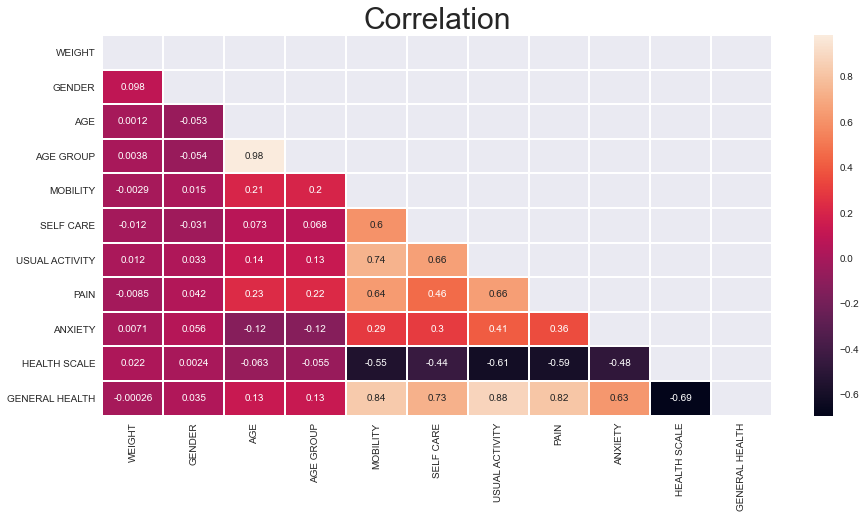

In [17]:
correlation = eq5d.corr()
plt.figure(figsize = (15,7))
mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(correlation, annot=True, mask=mask, linewidths=1)
plt.title('Correlation',fontsize=30)
plt.show()

In [18]:

w = widgets.Dropdown(options=eq5d.columns.tolist(), value='ANXIETY')
@interact(val=w)
def correlation(val):
     return eq5d.corrwith(eq5d[val]).plot.bar(figsize=(20,10),
                  title = 'Correlation with' ,
                  fontsize = 15,
                  grid = True)

interactive(children=(Dropdown(description='val', index=8, options=('WEIGHT', 'GENDER', 'AGE', 'AGE GROUP', 'M…

In [19]:
w2 = widgets.Dropdown(options=eq5d.columns.tolist(), value='PAIN')
@interact(Feature=w2)

def pie(Feature):
    X = pd.DataFrame(eq5d[Feature].value_counts())
    c = X.plot.pie(y=Feature,figsize=(10, 10),autopct='%1.0f%%' )
    c = plt.suptitle(Feature)
    c = plt.legend(loc="upper center", bbox_to_anchor=(1.2,0.71))
    #c = plt.axes().set_ylabel('')
    return c

interactive(children=(Dropdown(description='Feature', index=7, options=('WEIGHT', 'GENDER', 'AGE', 'AGE GROUP'…

Text(0, 0.5, 'Frequency')

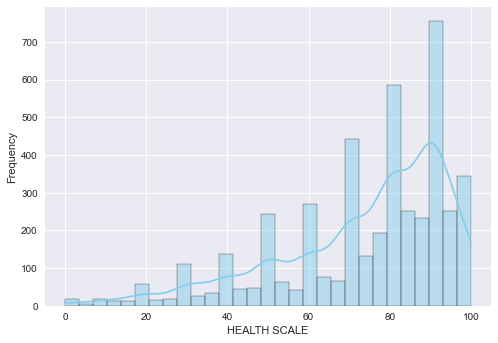

In [20]:
#samples =  eq5d["E6"]
ax = sns.histplot( eq5d["HEALTH SCALE"] , color="skyblue", label=' ',kde = True)
plt.ylabel('Frequency')

In [21]:
eq5dd = df[['COUNTRY', 'ID', 'WEIGHT', 'GENDER', 'AGE', 'AGER','E1', 'E2', 'E3', 'E4', 'E5', 'E6']].copy()
eq5dd.columns = ['COUNTRY', 'ID','WEIGHT', 'GENDER', 'AGE','AGE GROUP' ,'MOBILITY', 'SELF CARE', 'USUAL ACTIVITY', 'PAIN', 'ANXIETY', 'HEALTH SCALE']
#eq5d.head(3)
#eq5d.head(3)

In [22]:
ind = widgets.FloatRangeSlider(
    value=[60, 90],
    min=0,
    max=100.0,
    step=0.1,
    description='Utility Index:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

feauture = widgets.Dropdown(options=['MOBILITY', 'SELF CARE', 'USUAL ACTIVITY', 'PAIN', 'ANXIETY'], value='ANXIETY')
group = widgets.Dropdown(options=['COUNTRY', 'AGE GROUP', 'GENDER'], value='COUNTRY')

@interact(feauture=feauture,group=group,ind=ind)
def plot(feauture,group,ind):
    m = eq5dd.loc[(eq5dd['HEALTH SCALE'] >= ind[0]) & (eq5dd['HEALTH SCALE'] <= ind[1])]
    t = m.groupby([group,feauture])['ID'].count().sort_values(ascending=False).reset_index()
    ax=sns.barplot(data=t, \
                     x=group, \
                     y='ID', \
                     hue=feauture, \
                     palette=sns.color_palette( n_colors=5))
    ax.set( ylabel='counts')
    plt.title(feauture)
    plt.xticks(rotation=90)
    plt.legend(loc="upper center", bbox_to_anchor=(1.5, 1.15),)

interactive(children=(Dropdown(description='feauture', index=4, options=('MOBILITY', 'SELF CARE', 'USUAL ACTIV…

In [23]:
feauture_1 = widgets.Dropdown(options=['MOBILITY', 'SELF CARE','USUAL ACTIVITY', 'PAIN', 'ANXIETY'], value='ANXIETY')
feauture_2 = widgets.Dropdown(options=['MOBILITY', 'SELF CARE','USUAL ACTIVITY', 'PAIN', 'ANXIETY'], value='MOBILITY')
    
@interact(feauture_1=feauture_1,feauture_2=feauture_2)
def cross(feauture_1,feauture_2):
    c = pd.crosstab(eq5d[feauture_1], eq5d[feauture_2])
    c.loc['Total',:]= c.sum(axis=0)
    c.loc[:,'Total'] = c.sum(axis=1)
    return c

interactive(children=(Dropdown(description='feauture_1', index=4, options=('MOBILITY', 'SELF CARE', 'USUAL ACT…

In [24]:
eq5d.columns

Index(['WEIGHT', 'GENDER', 'AGE', 'AGE GROUP', 'MOBILITY', 'SELF CARE',
       'USUAL ACTIVITY', 'PAIN', 'ANXIETY', 'HEALTH SCALE', 'GENERAL HEALTH'],
      dtype='object')

In [25]:
feauture = widgets.Dropdown(options=['MOBILITY', 'SELF CARE','USUAL ACTIVITY', 'PAIN', 'ANXIETY'], value='MOBILITY')

@interact(feauture=feauture)
def joint(feauture):
    return sns.jointplot(x=eq5d['HEALTH SCALE'], y=eq5d[feauture], kind='kde',color = 'red')


interactive(children=(Dropdown(description='feauture', options=('MOBILITY', 'SELF CARE', 'USUAL ACTIVITY', 'PA…

In [28]:
def c():
    try:
        from pip._internal.operations import freeze
    except ImportError:  # pip < 10.0
        from pip.operations import freeze

    x = freeze.freeze()
    for p in x:
        print(p)


In [29]:
#new or state one [mobility]
#yes > break
mobility = ['Do u have a problem walking about today?',
              'Is it a slight problem ? ',
            'Hmmm, Moderate problem ? ',
            'Are you still able to walk about? ']
mobility_sc = [2,3,4,5]

#new or state one [selfCare]
#yes > break
selfCare = ['Do u have any problems with self care (e.g washing or dressing yourself) ? ',
              'Is it a slight problems ?',
            'Moderate problems? ',
            'Okay, Are you still able to wash or dress yourself?']
selfCare_sc = [2,3,4,5]

#new or state one [activity]
#yes > break
activity = ['Do u have problems performing usual activities (e.g. work, study, housework, family or leisure activities)? ',
              'Is it a slight problem ?',
            'Moderate problems? ',
            'Are you still able to perform any of your usual activities?']
activity_sc = [2,3,4,5]

#new or state one [pain]
#yes > break
pain = ['Do u have any pain or discomfort ?',
          'Is it a slight pain or discomfort ?',
        'Okay, On a scale of 1-3 (1 being the lowest and 3 being the highest) how to rate your pain or discomfort level?']
pain_sc = [2,3,4,5]


#new or state one[depression]
#yes > break
anxiety = ['Are u feeling anxious or depressed ?',
             'On a scale of 1-4 (1 being the lowest and 4 being the highest) how to rate your anxiety or depression level?']
anxiety_sc = [2,3,4,5]

In [30]:
# state 3 [mobility]
#yes > break
mobility_3 = ['Do u feel better or worse or the same at walking about today?',
              'Do u have any problem walking about?' ,
            'Are you still able to walk about? ']

#state 3 [selfCare]
#yes > break
selfCare_3 = ['Are you having less problems with self care (e.g washing or dressing yourself) than yesterday?',
              'Do u have slight problems regarding it  ?',
            'Okay, Are you still able to wash or dress yourself?',
            'Do u have moderate or severe problems regarding it  ?']

#state 3 [activity]
#yes > break
activity_3 = ['Are you feeling doing usual activities (e.g. work, study..) is easier or harder or the same as yesterday?',
              'Do u have slight problems doing usual activities ?',
            'Are you still able to perform any of your usual activities?',]


#state 3 [pain]
#yes > break
pain_3 = ['Regarding pain, Are you feeling better than yesterday? ',
          'Do u have any pain or discomfort ?',
        'Okay, On a scale of 1-3 (1 being the lowest and 3 being the highest) how to rate your pain or discomfort level?']

#state 3 [depression]
#yes > break
anxiety_3 = [ 'On a scale of 1-5 (1 being the lowest and 5 being the highest) how to rate your anxiety or depression level today?']

In [31]:
# state 4 [mobility]
#yes > break
mobility_4 = ['Do u feel better or worse or the same in walking about today?',
              'Good, Do u still have problems in walking about? ',
              'Slight or moderate problems ?']

#state 4 [selfCare]
#yes > break
selfCare_4 = ['Do u find it easier or harder or the same to wash or dress yourself ?',
              'Good, Do u still have any problems  wash or dress yourself? ',
              'Slight or moderate problems?']


#state 4 [activity]
#yes > break
activity_4 = ['Do u find it easier or harder or the same to do your usual activities today (e.g. work, study..)?',
              'Great, Do u still have any problems doing your usual activities?',
              'Slight or moderate problems?']

#state 4 [pain]
#yes > break
pain_4 = ['Regarding pain, Are you feeling better than yesterday? ',
          'Great, you do still have some pain or discomfort, right?',
          'Slight or moderate pain?',
        'same pain or worse?' ]

#state 4 [depression]
#yes > break
anxiety_4 = [ 'On a scale of 1-5 (1 being the lowest and 5 being the highest) how to rate your anxiety or depression level today?']

In [32]:
# state 5 [mobility]
#yes > break
mobility_5 = ['Are you able to walk about a little today?',
              'Good, Do u still have problems in walking about? ',
              'Okay, On a scale of 1-3 (1 being the lowest and 3 being the highest) how to rate your problems in walking about?']

#state 5 [selfCare]
#yes > break
selfCare_5 = [ 'Are you able to wash or dress yourself today? ',
              'Great, On a scale of 1-4 (1 being the lowest and 4 being the highest) how do u find it hard to wash or dress yourself?']


#state 5 [activity]
#yes > break
activity_5 = ['Have you done any usual activities today or able to (e.g. work, study..)?',
              'Great, On a scale of 1-4 (1 being the lowest and 4 being the highest) how do u find it hard to do your usual activities?']

#state 5 [pain]
#yes > break
pain_5 = ['Regarding pain, Are you feeling better than yesterday? ',
          'Great, you do still have some pain or discomfort, right?',
        'Okay, On a scale of 1-3 (1 being the lowest and 3 being the highest) how to rate your pain or discomfort level?']

#state 5 [depression]
#yes > break
anxiety_5 = [ 'On a scale of 1-5 (1 being the lowest and 5 being the highest) how to rate your anxiety or depression level today?']
anxiety_sc = [2,3,4,5]

In [36]:
from google_trans_new import google_translator  
translator = google_translator()

def convert(lang,questions):
    new_questions = []
    for i in questions:
        n = translator.translate(i,lang_tgt=lang)
        new_questions.append(n)
    return new_questions

In [37]:
import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import interactive, Layout
language = widgets.Dropdown(style= {'button_color':'red'},grid_area='sidebar',options=['af', 'sq', 'am', 'ar', 'hy', 'az', 'eu', 'be', 'bn', 'bs', 'bg', 'ca', 'ceb', 'ny', 'zh-cn', 'zh-tw', 'co', 'hr', 'cs', 'da', 'nl', 'en', 'eo', 'et', 'tl', 'fi', 'fr', 'fy', 'gl', 'ka', 'de', 'el', 'gu', 'ht', 'ha', 'haw', 'iw', 'he', 'hi', 'hmn', 'hu', 'is', 'ig', 'id', 'ga', 'it', 'ja', 'jw', 'kn', 'kk', 'km', 'ko', 'ku', 'ky', 'lo', 'la', 'lv', 'lt', 'lb', 'mk', 'mg', 'ms', 'ml', 'mt', 'mi', 'mr', 'mn', 'my', 'ne', 'no', 'or', 'ps', 'fa', 'pl', 'pt', 'pa', 'ro', 'ru', 'sm', 'gd', 'sr', 'st', 'sn', 'sd', 'si', 'sk', 'sl', 'so', 'es', 'su', 'sw', 'sv', 'tg', 'ta', 'te', 'th', 'tr', 'uk', 'ur', 'ug', 'uz', 'vi', 'cy', 'xh', 'yi', 'yo', 'zu'], value='en')
#language.style.handle_color = 'lightgreen'
#layout=Layout(width='50%', height='80px')
Mobility = widgets.BoundedIntText(value=3, min=1, max=5, step=1, description='Mobility',disabled=False)
SelfCare = widgets.BoundedIntText(value=5,  min=1, max=5, step=1, description='SelfCare ',disabled=False)
Activity = widgets.BoundedIntText(value=2, min=1, max=5, step=1, description='Activity',disabled=False)
Pain = widgets.BoundedIntText(value=4,  min=1, max=5, step=1, description='Pain',disabled=False)
Anxiety = widgets.BoundedIntText(value=1, min=1, max=5, step=1, description='Anxiety',disabled=False)

@interact(Mobility=Mobility,SelfCare=SelfCare,Activity=Activity,Pain=Pain,Anxiety =Anxiety,language = language)


def Questions(Mobility,SelfCare,Activity,Pain,Anxiety,language):

    
    if Mobility == 0 or Mobility == 1 or Mobility == 2 :           
            mob_questions = mobility
    if Mobility == 3 :
            mob_questions = mobility_3    
    if Mobility == 4 :
            mob_questions = mobility_4           
    if Mobility == 5 :
            mob_questions = mobility_5
                     
            
    if SelfCare == 0 or SelfCare == 1 or SelfCare == 2 :           
            sf_questions = selfCare
    if SelfCare == 3 :
            sf_questions = selfCare_3 
    if SelfCare == 4 :
            sf_questions = selfCare_4          
    if SelfCare == 5 :
            sf_questions = selfCare_4     
            
    if Activity == 0 or Activity == 1 or Activity == 2 :           
            act_questions = activity
    if Activity == 3 :
            act_questions = activity_3
    if Activity == 4 :
            act_questions = activity_4          
    if Activity == 5 :
            act_questions = activity_5      
            
            
            
    if Pain == 0 or Pain == 1 or Pain == 2 :           
            pn_questions = pain
    if Pain == 3 :
            pn_questions = pain_3
    if Pain == 4 :
            pn_questions = pain_4        
    if Pain == 5 :
            pn_questions = pain_5  
            
    if Anxiety == 0 or Anxiety == 1 or Anxiety == 2 :           
            ad_questions = anxiety
    if Anxiety== 3 :
            ad_questions = anxiety_3
    if Anxiety == 4 :
            ad_questions = anxiety_4          
    if Anxiety == 5 :
            ad_questions = anxiety_5    
            
            
            
    mob_questions = convert(language,mob_questions)
    sf_questions = convert(language,sf_questions)
    act_questions = convert(language,act_questions)
    pn_questions = convert(language,pn_questions)
    ad_questions = convert(language,ad_questions)
    
    #print("n\ ")

    return mob_questions,' ', sf_questions,' ', act_questions,' ', pn_questions,' ', ad_questions
    


interactive(children=(BoundedIntText(value=3, description='Mobility', max=5, min=1), BoundedIntText(value=5, d…